In [63]:
import numpy as np
import pandas as pd
import random
import time
import connect_four as cccc
import sys
import sklearn
from sklearn import *
from numpy import random

from sknn import *
import sknn
from sknn import mlp

from sknn.mlp import *

from sknn.mlp import Layer, Regressor, Classifier
import matplotlib as mpl

import matplotlib.pyplot as plt

from itertools import izip_longest as izip


%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = matplotlib.rcParams['savefig.dpi']

def progress_bar(percent, size = 20, message=''):
    percent = int(percent)
    fill = int(percent * size/100)
    sys.stdout.write('\r[' + 'X'*fill + ' '*(size-fill) + '] {:3d}% complete. '.format(percent) + message)
    sys.stdout.flush

In [ ]:
import pickle
with open('value.pkl','rb') as in_strm:
    v = pickle.load(in_strm)
with open('policy.pkl','rb') as in_strm:
    p = pickle.load(in_strm)
with open('parameters.pkl','rb') as in_strm:
    (training_data, target_data, current_write_index, temperature) = pickle.load(in_strm)

In [65]:
num_units=50
num_layers=1
dropout_rate = 0.25
batch_size = 128

policy = mlp.Regressor(layers = [Layer("Rectifier", units = num_units, dropout = dropout_rate)
                              for _ in range(num_layers)]+[Layer("Rectifier",units = 7)],
          learning_rule = "nesterov", learning_rate = 0.01, batch_size = batch_size, valid_size = 0.2,n_iter = 1)
value = mlp.Regressor(layers = [Layer("Tanh", units = num_units, dropout = dropout_rate) 
                              for _ in range(num_layers)]+[Layer("Tanh")],
          learning_rule = "nesterov", learning_rate = 0.01, batch_size = batch_size, valid_size = 0.2,n_iter = 1)



In [ ]:
saved_p = p.get_parameters()
saved_v = v.get_parameters()
saved_p = [[array for array in layer[:2]] for layer in saved_p]
saved_v = [[array for array in layer[:2]] for layer in saved_v]
policy.set_parameters(saved_p)
value.set_parameters(saved_v)

In [9]:
class rand_est():
    def __init__(self):
        None
    def predict(self,board):
        return np.random.rand(7)
    


In [66]:
    
policy.random_state=42
value.random_state=42
  
X = np.random.rand(batch_size,42)
# y = np.random.randint(0,7,(1000,1))

# policy.fit(X,y)
y = np.random.randint(0,1,(batch_size,7))
policy.fit(X,y)

y = np.random.rand(batch_size,1)*2-1

value.fit(X,y)

Regressor(batch_size=128, callback=None, debug=False, dropout_rate=None,
     f_stable=0.001,
     hidden0=<sknn.nn.Layer `Tanh`: units=50, name=u'hidden0', frozen=False, dropout=0.25>,
     layers=[<sknn.nn.Layer `Tanh`: units=50, name=u'hidden0', frozen=False, dropout=0.25>, <sknn.nn.Layer `Tanh`: units=1L, name=u'output', frozen=False>],
     learning_momentum=0.9, learning_rate=0.01, learning_rule='nesterov',
     loss_type=None, n_iter=1, n_stable=10,
     output=<sknn.nn.Layer `Tanh`: units=1L, name=u'output', frozen=False>,
     random_state=42, regularize=None,
     valid_set=(array([[ 0.74624,  0.76745, ...,  0.84413,  0.97539],
       [ 0.1692 ,  0.07922, ...,  0.65778,  0.7157 ],
       ...,
       [ 0.29927,  0.06333, ...,  0.73697,  0.26702],
       [ 0.62526,  0.28288, ...,  0.12404,  0.43028]]), array([[ 0.10931],
       [-0.46766],
       [-0.38773],
 ... ],
       [ 0.61837],
       [-0.04806],
       [ 0.76885],
       [-0.63439],
       [-0.56145]])),
     valid_size

In [4]:
len(policy.get_parameters())
for item in policy.get_parameters():
    print item.weights.shape
    print item.biases.shape

(42L, 150L)
(150L,)
(150L, 7L)
(7L,)


In [67]:
class rand_est():
    def __init__(self):
        None
    def predict(self,board):
        return np.random.rand(7)

inf = float("inf")
def policy_move(board, turn, policy = rand_est()):
    dummy_board = np.copy(board) * turn
    options = cccc.available_moves(dummy_board)  
    recommend = policy.predict(dummy_board.reshape(1,42))[0]
#     print recommend
    return sorted(options, key = lambda x:-1* recommend[x])


def partition(temp, total):
    return np.sum(np.exp(-1/float(temp) * np.arange(total)))

def probs(temp,total):
    if temp ==0:
        return np.ones(total)
    
    return np.cumsum(np.exp(-1/float(temp) * np.arange(total)) / partition(temp,total))

#returns the index of a sorted list of moves
def boltz_move(temp,total):
    x = np.random.random()
    return np.argmax(x < probs(temp,total))

#get self-play moves with policy_move(board,turn,policy)[boltz_move(temp,len(options))]

class nn_ai:
    
    def __init__(self,policy,temp = 0):
        self.temp = temp
        self.policy = policy
    
    def make_move(self,board,active_turn):
        options = cccc.available_moves(board)
        return policy_move(board, active_turn, self.policy)[boltz_move(self.temp, len(options))]+1

In [68]:
def alpha_beta_move(board, turn, depth = 0, alpha = -inf, beta = inf, evaluation = lambda x: 0):
    dummy_board = np.copy(board) # we don't want to change the board state

    swap_player = {1:-1,-1:1} # So we can change whose turn
    options = cccc.available_moves(board) # get legal moves
    random.shuffle(options) # should inherit move order instead of randomizing

    best_value = -inf
    
    if not options:
        print board, cccc.game_over(board)
        print 'oops, no available moves'
    cand_move = options[0]
    if depth == 0: 
        for x in options:
            update_move(dummy_board,x,turn)
            op_value = evaluation(dummy_board*swap_player[turn])

            if -op_value > best_value:
                cand_move = x
                best_value = -op_value
                alpha = max(alpha, best_value)
            if alpha >= beta:
                break   #alpha-beta cutoff
            unupdate_move(dummy_board,x)
    else:
    
        for x in options:
            update_move(dummy_board,x,turn)
        
            if cccc.winner(dummy_board): #should check over and tied too
                return(inf, x)
            
            if cccc.is_full(dummy_board): #This assumes you can't lose on your turn
                return(0 , x)
            
            op_value,_ = alpha_beta_move( dummy_board,
                                            swap_player[turn],
                                            depth-1,
                                            alpha = - beta,
                                            beta = - alpha,
                                            evaluation = evaluation)

            if -op_value > best_value:
                cand_move = x
                best_value = -op_value
                alpha = max(alpha, best_value)
            if alpha >= beta:
                break   #alpha-beta cutoff
            unupdate_move(dummy_board,x)
    return (best_value, cand_move)

class Alpha_Beta:
    def __init__(self,depth):
        self.depth = depth
    def make_move(self,board,active_turn):
        #print (board,active_turn,self.depth)
        return alpha_beta_move(board,active_turn,self.depth)[1]+1

def one_where(num):
    array = np.zeros(7)
    array[num] = 1
    return array
    

def get_inputs(log):
    boards = []
    piece = 1
    board = np.zeros((6,7))
    boards.append(np.copy(board))
    for move in log:
        board[np.where(board[:,move-1]==0)[0][-1],move-1] = piece
        piece = -piece
        boards.append(np.copy(board))
    return boards

In [69]:

def update_move(board, move, turn):
    board[np.where(board[:,move]==0)[0][-1], move] = turn
    return None
    
def unupdate_move(board, move):
    if 0 in board[:,move]:
        board[np.where(board[:,move]==0)[0][-1]+1, move] = 0
    else:
        board[0,move]=0
    return None

def value_move(board,active_turn):
    dummy_board = np.copy(board).reshape((6,7))*active_turn
    options = cccc.available_moves(dummy_board)
    if not options:
        return 0
    
    moves = np.zeros(7)
    move_values = np.zeros(7)
    if len(options )== 1:
        return options[0]
    for choice in options:
        update_move(dummy_board, choice, 1)
        if cccc.winner(dummy_board):
            move_values[choice] =  cccc.winner(dummy_board)
            unupdate_move(dummy_board,choice)
            continue
        reshapeable = np.copy(dummy_board)
        move_values[choice] = -1 * value.predict(-1 * reshapeable.reshape((1,42)))
        unupdate_move(dummy_board, choice)
#    print move_values
#     available_move_values = np.array([move_values[move] for move in options])

#     move = options[available_move_values.argmax(-1)]
#     moves[move] += 1

#     move = np.argmax(moves)
    return max(options, key = lambda x: move_values[x])



In [70]:
def validate(validation_str = 0):

    test_result = {'wins':0,'ties':0,'losses':0}
    for j in range(100):
#             sys.stdout.write('\r playing validation game {:4d} of {:4d}'.format(j+1, 1000))
#             sys.stdout.flush()
        result = cccc.play(nn_ai(player_1,temp=0),Alpha_Beta(0))
        if result.winner ==1:
            test_result['wins'] +=1
        if result.winner == 0:
            test_result['ties'] +=1
        if result.winner == -1:
            test_result['losses'] +=1

         
    print 'As X, neural network has a score of {:3d}-{:3d}-{:3d} vs {}-depth minimax'.format(test_result['wins'],
                                                           test_result['ties'],test_result['losses'],validation_str)

    test_result = {'wins':0,'ties':0,'losses':0}

    for j in range(100):
#             sys.stdout.write('\r playing validation game {:4d} of {:4d}'.format(j+1, 1000))
#             sys.stdout.flush()
        result = cccc.play(Alpha_Beta(0),nn_ai(player_2,temp=0))
        if result.winner ==1:
            test_result['losses'] +=1
        if result.winner == 0:
            test_result['ties'] +=1
        if result.winner == -1:
            test_result['wins'] +=1
#         print '\n'
    print 'As O, neural network has a score of {:3d}-{:3d}-{:3d} vs {}-depth minimax'.format(test_result['wins'],
                                                        test_result['ties'],test_result['losses'],validation_str)
    print 'epoch time: {:3.3f}s'.format(time.clock()-t0)
    # save the chromes

In [19]:
sum(item[0].size+item[1].size for item in value.get_parameters())

6601

In [10]:
np.zeros((6,7)).size

42

In [74]:
training_size = sum(item[0].size+item[1].size for item in value.get_parameters()) * 50
training_data = [np.zeros((6,7))]*training_size
target_data = [0]*training_size
current_write_index = 0
temperature = 2
print training_size

110050


In [48]:
temperature = 0.7

Starting Epoch 0, temperature = 2.00
[XXXXXXXXXXXXXXXXXXXX] 100% complete. games played: 110050

[XXXXXXXXXXXXXXXXXXXX] 100% complete. training value net

[XXXXXXXXXXXXXXXXXXXX] 100% complete. building policy targets

[XXXXXXXXXXXXXXXXXXXX] 100% complete. training policy net

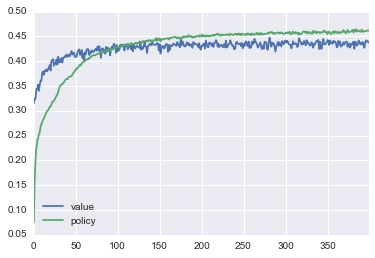

value = 0.437960021256, policy = 0.461520709798 epoch 0 complete
As X, neural network has a score of  98-  0-  2 vs 0-depth minimax
As O, neural network has a score of  89-  0- 11 vs 0-depth minimax
epoch time: 3745.799s
Starting Epoch 1, temperature = 1.83
[XXXXXXXXXXXXXXXXXXXX] 100% complete. games played: 220100

[XXXXXXXXXXXXXXXXXXXX] 100% complete. training value net

[XXXXXXXXXXXXXXXXXXXX] 100% complete. building policy targets

[XXXXXXXXXXXXXXXXXXXX] 100% complete. training policy net

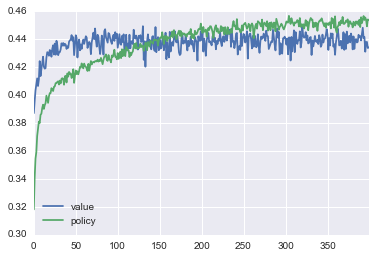

value = 0.434267066641, policy = 0.454092142411 epoch 1 complete
As X, neural network has a score of  99-  0-  1 vs 0-depth minimax
As O, neural network has a score of  93-  0-  7 vs 0-depth minimax
epoch time: 3591.807s
Starting Epoch 2, temperature = 1.68
[XXXXXXXXXXXXXXXXXXXX] 100% complete. games played: 330150

[XXXXXXXXXXXXXXXXXXXX] 100% complete. training value net

[XXXXXXXXXXXXXXXXXXXX] 100% complete. building policy targets

[XXXXXXXXXXXXXXXXXXXX] 100% complete. training policy net

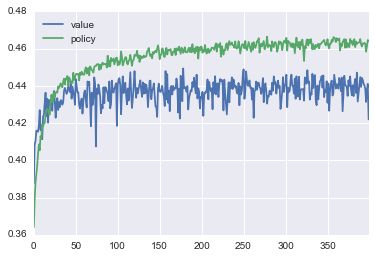

value = 0.422065114634, policy = 0.464121473853 epoch 2 complete
As X, neural network has a score of  98-  0-  2 vs 0-depth minimax
As O, neural network has a score of  97-  0-  3 vs 0-depth minimax
epoch time: 3379.598s
Starting Epoch 3, temperature = 1.54
[XXXXXXXXXXXXXXXXXXXX] 100% complete. games played: 440200

[XXXXXXXXXXXXXXXXXXXX] 100% complete. training value net

[XXXXXXXXXXXXXXXXXXXX] 100% complete. building policy targets

[XXXXXXXXXXXXXXXXXXXX] 100% complete. training policy net

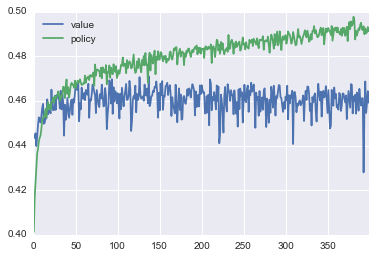

value = 0.459230552006, policy = 0.491218487806 epoch 3 complete
As X, neural network has a score of  95-  0-  5 vs 0-depth minimax
As O, neural network has a score of  90-  0- 10 vs 0-depth minimax
epoch time: 3197.746s
Starting Epoch 4, temperature = 1.42
[XXXXXXXXXXXXXXXXXXXX] 100% complete. games played: 550250

[XXXXXXXXXXXXXXXXXXXX] 100% complete. training value net

[XXXXXXXXXXXXXXXXXXXX] 100% complete. building policy targets

[XXXXXXXXXXXXXXXXXXXX] 100% complete. training policy net

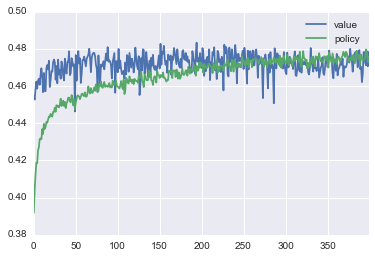

value = 0.478291548814, policy = 0.475572269547 epoch 4 complete
As X, neural network has a score of  94-  0-  6 vs 0-depth minimax
As O, neural network has a score of  97-  0-  3 vs 0-depth minimax
epoch time: 3320.314s
Starting Epoch 5, temperature = 1.30
[XXXXXXXXXXXXXXXXXXXX] 100% complete. games played: 660300

[XXXXXXXXXXXXXXXXXXXX] 100% complete. training value net

[XXXXXXXXXXXXXXXXXXXX] 100% complete. building policy targets

[XXXXXXXXXXXXXXXXXXXX] 100% complete. training policy net

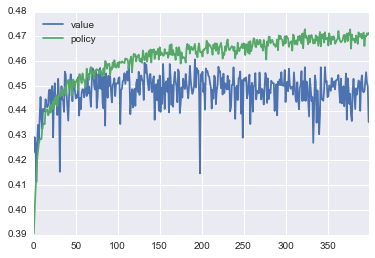

value = 0.435488702901, policy = 0.471397118134 epoch 5 complete
As X, neural network has a score of  95-  0-  5 vs 0-depth minimax
As O, neural network has a score of  92-  0-  8 vs 0-depth minimax
epoch time: 3266.131s
Starting Epoch 6, temperature = 1.20
[XXXXXXXXXXXXXXXXXXXX] 100% complete. games played: 770350

[XXXXXXXXXXXXXXXXXXXX] 100% complete. training value net

[XXXXXXXXXXXXXXXXXXXX] 100% complete. building policy targets

[XXXXXXXXXXXXXXXXXXXX] 100% complete. training policy net

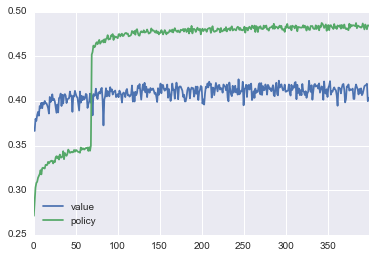

value = 0.403497477123, policy = 0.484498338167 epoch 6 complete
As X, neural network has a score of  92-  0-  8 vs 0-depth minimax
As O, neural network has a score of  92-  0-  8 vs 0-depth minimax
epoch time: 3303.699s
Starting Epoch 7, temperature = 1.11
[XXXXXXXXXXXXXXXXXXXX] 100% complete. games played: 880400

[XXXXXXXXXXXXXXXXXXXX] 100% complete. training value net

[XXXXXXXXXXXXXXXXXXXX] 100% complete. building policy targets

[                    ]   1% complete. training policy net

KeyboardInterrupt: 

In [75]:
train_duration = 100
min_temperature = 0.3
self_play = 0
temporal_index = 0.8
mini_epoch_policy = 400
mini_epoch_value = 400
refresh_rate = 1
for epoch in range(train_duration):
    t0 = time.clock()
    print "Starting Epoch {}, temperature = {:.2f}".format(epoch,temperature)
    for train_i in range(training_size/refresh_rate):
        t1 = time.clock()

        player_1 = policy
        player_2 = policy
        play_result = cccc.play(nn_ai(player_1,temp = temperature),nn_ai(player_2,temp=temperature))
        learning_selection = random.choice(range(len(play_result.log)+1))
        boards = get_inputs(play_result.log)[learning_selection:]
        learning_board = boards[0]

        if learning_selection % 2 ==0:
            learning_player = 1
        else:
            learning_player = -1
        self_play +=1
        learning_pool = []
        value_history = []

#        current_state = learning_board * learning_player
        current_player = learning_player
        learning_board = learning_player * learning_board
    #    print play_result.log
        for board in boards[:-1]:
            board = board * current_player
    #        print board
    #        board = board * current_player
    #        next_value , next_state , explore = play_one_move(current_state,value_funs)
    #        next_value = value.predict(current_state)
            learning_pool.append(board.reshape((1,42)))
            value_history.append(value.predict(board.reshape((1,42)))[0])
            current_player *= -1

        learning_pool.append(boards[-1]*current_player)

        value_history.append(cccc.winner(boards[-1]*current_player))


        future_board = learning_pool.pop()
        learning_target = value_history.pop()
        while(value_history):
            learning_target = -1 * temporal_index * learning_target + (1-temporal_index)*value_history.pop()
        training_data[current_write_index%training_size] = learning_board
        target_data[current_write_index%training_size] = learning_target   
        current_write_index +=1

        if train_i%(training_size / refresh_rate / 10)==0:
            progress_bar(100.*float(train_i+1) / (training_size / refresh_rate),message = "games played: {}".format(current_write_index))
            
    #    if train_i %(training_size/10)==0:
    #        print "\n"
    progress_bar(100,message = "games played: {}".format(current_write_index)) #ascthetic only
    if current_write_index < training_size:
        
        print '\n'
        continue
    
    X_train =np.array(training_data[:3*training_size/4] ).reshape(3*training_size/4,42)
    X_test = np.array(training_data[3*training_size/4:]).reshape(training_size-3*training_size/4,42)
    y_train = np.array(target_data[:3*training_size/4]).reshape(3*training_size/4,1)
    y_test = np.array(target_data[3*training_size/4:]).reshape(training_size - 3*training_size/4,1)
    print '\n'
    policy_scores = []
    value_scores = []
    for mini_epoch in range(mini_epoch_value):
        progress_bar(float(mini_epoch+1) / mini_epoch_value*100, message = "training value net")
        value.fit(X_train,y_train)
        value_scores.append(value.score(X_test,y_test))
    zeros = np.zeros(7)
    progress_bar(100, message = "training value net")#ascthetic only
    print '\n'
    policy_targets = [progress_bar(float(i) / training_size*100, message = "building policy targets")
                      or one_where(value_move(board, 1)) for i,board in enumerate(training_data)]
    z_train = np.array(policy_targets[:3*training_size/4]).reshape(3*training_size/4,7)
    z_test = np.array(policy_targets[3*training_size/4:]).reshape(training_size - 3*training_size/4,7)
    progress_bar(100, message = "building policy targets")#ascthetic only
    print '\n'
    for mini_epoch in range(mini_epoch_policy):
        
        progress_bar(float(mini_epoch+1) / mini_epoch_policy*100,message = "training policy net")
        policy.fit(X_train,z_train)
        policy_scores.append(policy.score(X_test,z_test))
    progress_bar(100,message = "training policy net") # ascthetic only
#     print "\n"
    pd.DataFrame(list(izip(value_scores,policy_scores, fillvalue = float("nan"))),columns=['value','policy']).plot()
    plt.show()
    print "value = {}, policy = {} epoch {} complete".format(value.score(X_test,y_test),policy.score(X_test,z_test), epoch)
    validate()
    temperature = (temperature - min_temperature)*0.9 + min_temperature
           


In [51]:
with open('value.pkl','wb') as out_strm:
    pickle.dump(value,out_strm)
with open('policy.pkl','wb') as out_strm:
    pickle.dump(policy,out_strm)
with open('parameters.pkl','wb') as out_strm:
    pickle.dump((training_data, target_data, current_write_index, temperature),out_strm)

In [3]:
import pickle
with open('value.pkl','rb') as in_strm:
    value = pickle.load(in_strm)
with open('policy.pkl','rb') as in_strm:
    policy = pickle.load(in_strm)
with open('parameters.pkl','rb') as in_strm:
    (training_data, target_data, current_write_index, temperature) = pickle.load(in_strm)

In [57]:
training_data.count(training_data[0],)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [60]:
stuff = [str(array) for array in training_data]

In [ ]:
for thing in stuff:
    print stuff.count(thing)

9
83
148
1196
24
671
1196
2
34
1771
9
34
1771
763
1771
87
4
16
148
1196
49
5
32
23
80
2
3
565
1253
393
16
260
15
671
6
915
187
1
9
4
94
161
1253
4
1196
874
1196
12
12
72
1196
1771
1
54
300
434
1659
2
2
5
70
438
32
20
17
8
874
1
167
1253
1659
5
147
34
1659
5
36
1
76
204
131
6
1
1
393
26
41
103
100
131
12
1771
64
2
9
438
1413
10
162
1659
2
1659
7
565
4
37
1
671
1413
195
671
1771
1771
763
1413
6
671
1253
276
109
1253
532
671
52
671
1
2
89
4
1196
1
565
131
2
671
106
18
565
4
1771
1
1771
153
1659
1253
22
27
24
5
260
109
87
54
16
147
6
1253
1413
1413
1659
1771
7
6
40
61
178
2
874
4
112
204
147
915
59
204
874
103
915
1253
1253
1
256
3
40
89
16
1
131
1253
1253
1253
393
300
1659
108
231
7
1
1
532
915
148
763
15
1
208
260
18
763
1659
32
1
2
874
1659
1413
161
763
133
41
1413
63
1
98
1
13
1
187
1196
34
68
21
393
5
434
45
1253
1253
565
1196
1659
4
1196
1771
99
6
260
42
94
532
204
6
26
300
112
1771
1196
32
3
1253
12
565
915
14
313
224
10
874
14
671
224
1771
434
23
3
94
438
133
915
915
1196
30
532
11

In [182]:
saved_p = [[array for array in layer[:2]] for layer in saved_p]
saved_v = [[array for array in layer[:2]] for layer in saved_v]
policy.set_parameters(saved_p)
value.set_parameters(saved_v)

In [175]:
print policy.get_parameters()[0][1]==saved_p[0][1]


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]


In [126]:
np.array(p.get_parameters())[0][0]==np.array(policy.get_parameters())[0][0]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

In [36]:
v_para = value.get_parameters()
p_para = policy.get_parameters()

In [42]:
v_para = [[array for array in layer[:2]] for layer in v_para]
p_para = [[array for array in layer[:2]] for layer in p_para]

value.set_parameters(v_para) 
policy.set_parameters(p_para)

In [19]:
import pickle
with open('parameters2', 'rb') as in_strm:
        v,p,training_data,target_data,current_write_index = pickle.load(in_strm)

In [46]:
policy.set_parameters(list(p))

ValueError: too many values to unpack

In [35]:
value.predict(-boards[0].reshape((1,42)))

array([[-0.40694909]])

In [33]:
boards[0]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1., -1.,  0., -1.,  0.],
       [ 0.,  0.,  1.,  1.,  0., -1.,  0.],
       [-1.,  0.,  1.,  1.,  0., -1.,  0.]])

In [45]:
policy.get_parameters()

[Parameters(weights=array([[ 0.10713747, -0.11199324,  0.10277964, ..., -0.03107075,
        -0.1648835 , -0.05584284],
       [ 0.04986459,  0.06363781,  0.01551032, ...,  0.16507727,
        -0.01411279,  0.11935348],
       [-0.10634266, -0.03136429,  0.07384725, ..., -0.05273866,
         0.07376527, -0.00728419],
       ..., 
       [ 0.16502712, -0.10894664,  0.0820191 , ..., -0.1020957 ,
        -0.06141815,  0.11160652],
       [ 0.01521472,  0.1271042 , -0.09782301, ..., -0.03381845,
         0.1753141 , -0.11578896],
       [ 0.06263408, -0.11556657,  0.08329605, ...,  0.071731  ,
        -0.04514209, -0.17116802]]), biases=array([  3.77970966e-03,  -2.10656906e-04,   7.74439963e-03,
        -8.34223206e-04,   3.78463112e-03,  -3.16353173e-03,
        -2.83451546e-04,  -1.95067843e-03,  -5.73721080e-03,
        -1.13304378e-03,  -3.90153449e-04,  -3.22483137e-03,
        -4.15094938e-03,  -1.76362650e-03,  -7.08357228e-03,
        -3.57063931e-05,  -1.15433647e-03,  -1.607761

In [128]:
print policy.predict(X_train[i].reshape((1,42)))
print policy_move(X_train[i].reshape((6,7)),1,policy)
print value_move(X_train[i].reshape((6,7)),1)

[[  0.00000000e+00   1.05718265e-01   2.05222898e-02   0.00000000e+00
    5.55111512e-17   0.00000000e+00   6.81224115e-01]]
[1, 2, 4, 0, 3]
[ 0.06019007  0.04614589 -1.          0.00267254  0.05088697  0.          0.        ]
0


In [120]:
dummy_board = X_train[14].reshape((6,7))
options = cccc.available_moves(dummy_board)
print options

moves = np.zeros(7)
move_values = np.zeros(7)

for choice in options:
    update_move(dummy_board, choice, 1)
    reshapeable = np.copy(dummy_board)
    move_values[choice] = -1 * value.predict(-1 * reshapeable.reshape((1,42)))
    unupdate_move(dummy_board, choice)
print move_values
print max(options, key = lambda x:  move_values[x])

[0, 1, 2, 3, 4]
[ 0.06019007  0.04614589  0.17373381  0.00267254  0.05088697  0.          0.        ]
2


In [30]:
train_duration = 100
scores = []
for epoch in range(100):
    
    value.fit(X_train,y_train)
    policy.fit(X_train,z_train)
    
    scores.append((value.score(X_test,y_test),policy.score(X_test,z_test)))
    print "value = {}, policy = {} epoch {} complete".format(scores[-1][0],scores[-1][1], epoch)
           


value = 0.120798554732, policy = -0.437051063332 epoch 0 complete
value = 0.101803571257, policy = -0.284918307083 epoch 1 complete
value = 0.09770518044, policy = -0.251997171308 epoch 2 complete
value = 0.0860769768841, policy = -0.2462004443 epoch 3 complete
value = 0.113245520518, policy = -0.31231018018 epoch 4 complete
value = 0.115281285356, policy = -0.300428208949 epoch 5 complete
value = 0.0599270240985, policy = -0.293244037285 epoch 6 complete
value = 0.0996128519659, policy = -0.270490540291 epoch 7 complete
value = 0.0959149105556, policy = -0.26012062539 epoch 8 complete
value = 0.101433792129, policy = -0.218059443375 epoch 9 complete
value = 0.0986670612722, policy = -0.233956916815 epoch 10 complete
value = 0.0932080401872, policy = -0.203944635185 epoch 11 complete
value = 0.0940497570382, policy = -0.184805294441 epoch 12 complete
value = 0.084254668461, policy = -0.191887068805 epoch 13 complete
value = 0.0949794012475, policy = -0.186291115696 epoch 14 complete
va

KeyboardInterrupt: 

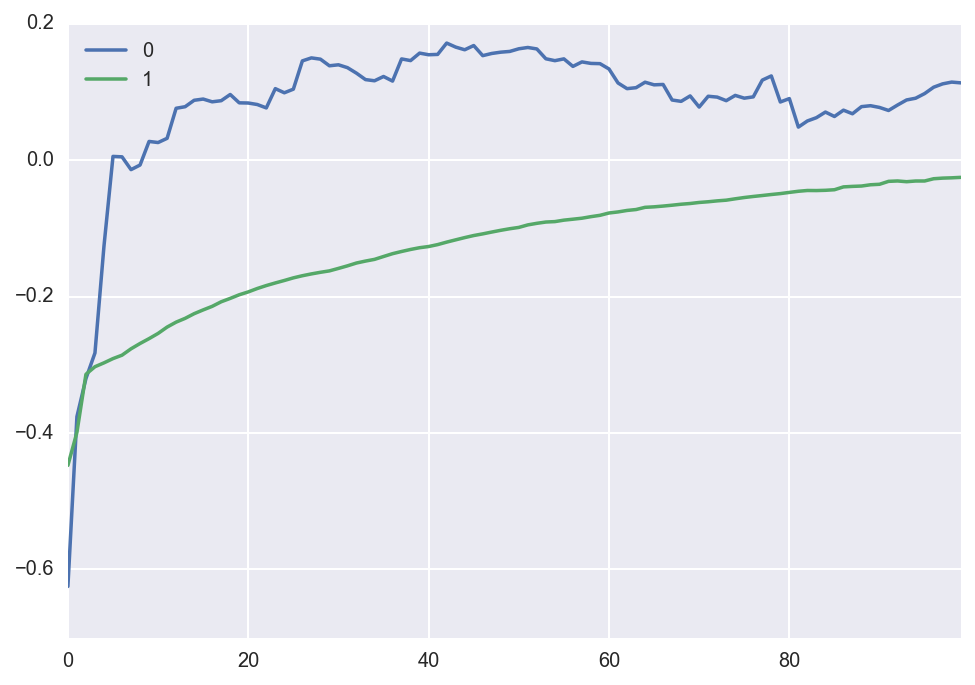

In [28]:
import pandas as pd
(pd.DataFrame(scores)).plot()

In [76]:
len(y)

128